# CLIP GradCAM Colab

This Colab notebook uses [GradCAM](https://arxiv.org/abs/1610.02391) on OpenAI's [CLIP](https://openai.com/blog/clip/) model to produce a heatmap highlighting which regions in an image activate the most to a given caption.

This notebook is heavily adapted from the original GradCAM notebook from the `clip-playground` GitHub repo (at https://github.com/kevinzakka/clip_playground), but is adapted and annotated for use with more powerful ViT CLIP variants (specifically PyTorch models built with the Hugging Face Transformers library). 

##Dependencies and setup 

###Installations

Note: this notebook was built on Google Colab whose environments contain many pre-installed libraries; for running locally, you may need to run `pip install` for additional libraries in the below section if they are not already installed on your machine. 

In [1]:
#Transformers library - Hugging Face model framework which incl. CLIP models
!pip install transformers

#A library for running GradCAM on a variety of PyTorch models 
#Contains useful helper functions for plotting GradCAM outputs; the actual GradCAM
#implementations are not used here
!pip install grad-cam

#Legacy import from the OpenAI CLIP implementation - use in future notebooks 
# !pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Imports 

In [2]:
#Basic operations
import sys, os
import requests
from tqdm import tqdm
from glob import glob
import numpy as np
import pandas as pd

#Image and display utilities
import urllib.request 
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import filters
from PIL import Image
import cv2
%matplotlib inline

#Deep learning
import torch
from torch import nn
import torch.nn.functional as F
#import clip #OpenAI CLIP 
from transformers import (
    CLIPModel,
    CLIPProcessor, 
    CLIPTokenizer,
    CLIPFeatureExtractor
)#For Hugging Face pretrained
from transformers import (
    VisionTextDualEncoderModel, 
    VisionTextDualEncoderProcessor, 
    AutoTokenizer, 
    AutoFeatureExtractor
) #For Hugging Face fine-tuned/trained from scratch

#GradCAM utilities
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

###Google Drive setup

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Navigate to drive to access models, data, etc. 
#Run additional cells for further navigation  
%cd /content/drive/MyDrive/

/content/drive/MyDrive


##Implementation 

Several helper functions and GradCAM implementation on ViT image encoder in this section. Again, these are slightly modified from the initial implementation in `clip_playground`, but will be more heavily annotated (mostly for author's understanding, but may be helpful for further modification (e.g. for adapting to models built in TF/Keras - may come in the future). 

###Image display/normalization methods

Direct from https://github.com/kevinzakka/clip_playground. 

In [5]:
def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x
    
def load_image(img_path, resize=None):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.

###GradCAM Methods

Adapted from https://github.com/kevinzakka/clip_playground: 

This GradCAM implementation registers a forward hook on the model at the specified layer. This allows us to save the intermediate activations and gradients at that layer.

To visualize which parts of the image activate for a given caption, we use the caption as the target label and backprop through the network using the image as the input. **In the case of CLIP models with Vision Transformer encoders, we save the activation and gradients from a given attention block as specified by the user. Note that as described in [the pytorch-grad-cam respository](https://github.com/jacobgil/pytorch-grad-cam/blob/master/tutorials/vision_transformers.md), the image representation from the final attention block is not used by the Vision Transformer for classification, and so the gradient with respect to the outputs of this final block will be 0 (useless for GradCAM) - therefore, the last informative attention block of the ViT encoder which can be used is the penultimate one. 

In [6]:
#Building the Hook object
class Hook:
    """Attaches to a module and records its activations and gradients."""
    #Create hook on the given model layer
    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    #Save gradients    
    def save_grad(self, module, input, output):
        self.data = output
        for elem in output:
          elem.requires_grad_(True)
          elem.retain_grad()
        
    def __enter__(self):
        return self
    
    #Remove hook
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    #Fetch the values of the named components    
    @property
    def activation(self) -> torch.Tensor:
        return self.data[0]
    
    @property
    def gradient(self) -> torch.Tensor:
        return self.data[0].grad

In [7]:
# Reference: https://arxiv.org/abs/1610.02391
def gradCAM(
    model: nn.Module,
    input: torch.Tensor,
    target: torch.Tensor,
    layer: nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()
        
    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)
        
    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)

    with Hook(layer) as hook:        
        """Forward pass for ViT-based Hugging Face CLIP models is complex.

        First, we pass the image input into our vision model, where the
        relevant representation is captured in the .pooler_output attribute.

        We then pass this representation through a final model layer
        to get an output in the joint image-text embedding space."""
        output = model.visual_projection(model.vision_model(input).pooler_output)
        #Backward pass from the text embedding 
        output.backward(target)

        #Get gradient and activation values 
        grad = hook.gradient.float()
        act = hook.activation.float()
    
        """For a single image from a ViT embedding, our gradient (and 
        activation) dimensions are (1, 50, 768), which get reinterpreted
        for the GradCAM context as below:
          * 1 = batch size
          * 50 = from the Vision Transformers page on the pytorch-grad-cam
            repo, "the first element represents the class token, and the rest 
            represent the [7x7] patches in the image". This is common to 
            all Hugging Face CLIP models I've seen, but other ViTs may have
            a dimension of 197 (1 + 14x14) with double-resolution for image
            patches. 
          * 768 = number of channels. This is a common hidden-layer size for 
            many Transformers (e.g. BERT), but other ViTs may have a dimension 
            of 192. 
        
        We will need to reshape the gradient and activation tensors to 
        torch.Size([1, 768, 7, 7]). In future iterations or for more rigorous
        tool-building, these numbers shouldn't be hard-coded."""

        #The reshaping strategy suggested in pytorch-grad-cam docs
        grad_corrected = grad[:, 1 :  , :].reshape(grad.size(0),
        7, 7, grad.size(2))
        
        #Transpose remaining axes of the tensor. 
        grad_corrected = torch.transpose(grad_corrected, 3, 1)
        grad_corrected = torch.transpose(grad_corrected, 3, 2)

        #Reshape activations 
        act_corrected = act[:, 1 :  , :].reshape(act.size(0),
        7, 7, act.size(2))
        act_corrected = torch.transpose(act_corrected, 3, 1)
        act_corrected = torch.transpose(act_corrected, 3, 2)

        """Now that gradients have been obtained, we global-average-pool 
        the gradients across the spatial dimension to obtain importance 
        weights."""
        alpha = grad_corrected.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel
        # dimension.
        gradcam = torch.sum(act_corrected * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence so we
        # clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(
        gradcam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)
    
    # """In a few test images, some of the interpolated values came out slightly 
    # negative and threw off the default pytorch-grad-cam visualization method - 
    # we fix this here by re-clamping the gradcam output."""
    # gradcam = torch.clamp(gradcam, min=0, max=1)
    
    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])
        
    return gradcam

##Running GradCAM

We will again closely follow the `clip_playground` implementation of an interactive Colab interface for running single-image GradCAM. 

###Hugging Face model

In [8]:
#For GPU inference
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [9]:
#@title #### Model custom settings
#@markdown If you have custom Hugging Face CLIP settings 
#@markdown you would like to use for visualization, fill in 
#@markdown the variables below to load your specific model. 
#@markdown Otherwise, a default pretrained Hugging Face CLIP 
#@markdown will be used instead. 

#@markdown Some details for each option:
#@markdown * `model_path` - `str`, path to a 
#@markdown locally-saved CLIP model
#@markdown * `tokenizer_path` - `str`, path to a 
#@markdown locally_saved tokenizer (must have saved both 
#@markdown the tokenizer and config to this path or errors may occur)
#@markdown * `tokenizer_type` - `str`, the name of a 
#@markdown specific pretrained tokenizer (e.g. `roberta-base`) 
#@markdown if a CLIP model was finetuned but the tokenizer 
#@markdown was not (should not be specified in tandem with 
#@markdown `tokenizer_path`)
#@markdown * `feature_ext_path`, `feature_ext_type` - 
#@markdown `str`, same as for tokenizers
#@markdown * `processor_path` - `str`, path to a locally-saved 
#@markdown CLIP processor 

#@markdown For more details on how to use these, see the 
#@markdown Hugging Face documentation for `CLIPModel` and 
#@markdown `VisionTextDualEncoder`. The main thing to pay 
#@markdown attention to is consistency between the types of model, 
#@markdown tokenizer, feature extractor and processor used - 
#@markdown if a non-default model is specified (i.e. 
#@markdown `VisionTextDualEncoder`), then the corresponding 
#@markdown tokenizer and feature extractors should also be 
#@markdown specified too (at the very least their types, if 
#@markdown they were not downloaded/retrained locally).  

#Variables to fill in
model_path = '' #@param {type:"string"}
tokenizer_path = '' #@param {type:"string"}
tokenizer_type = '' #@param {type:"string"}
feature_extractor_path = '' #@param {type:"string"}
feature_extractor_type = '' #@param {type:"string"}

#model setup
model = None
if model_path != '':
  model = VisionTextDualEncoderModel.from_pretrained(model_path)
else:
  model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)
 
#tokenizer setup
tokenizer = None
if tokenizer_path != '':
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
elif tokenizer_type != '':
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_type)

#feature extractor setup 
feat_ext = None
if feature_extractor_path != '':
  feat_ext = AutoFeatureExtractor.from_pretrained(feature_extractor_path)
elif tokenizer_type != '':
  tokenizer = AutoFeatureExtractor.from_pretrained(feature_extractor_type)

#processor setup - 
#use the CLIP default if tokenizer/feat ext not specified
processor = None
if tokenizer is not None and feat_ext is not None:
  processor = VisionTextDualEncoderProcessor(feat_ext, tokenizer)
elif tokenizer is None and feat_ext is not None:
  tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
  processor = VisionTextDualEncoderProcessor(feat_ext, tokenizer)
elif tokenizer is not None and feat_ext is None:
  feat_ext = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")
  processor = VisionTextDualEncoderProcessor(feat_ext, tokenizer)
else:
  processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [10]:
#@title #### GradCAM settings
#@markdown Choose GradCAM and visualization here. 

attention_head = "11" #@param [1,2,3,4,5,6,7,8,9,10,11]
visualization_size = "large" #@param ["small", "medium", "large"]
visualization_style = "heatmap" #@param ["heatmap", "brightness map"]

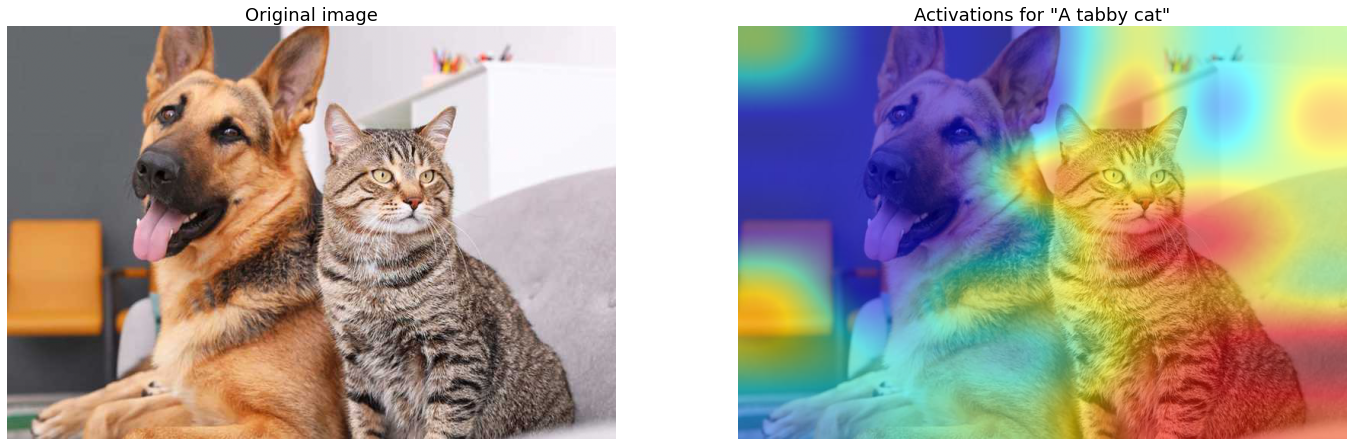

In [11]:
#@title #### Run on single image

image_url = 'https://images.ctfassets.net/82d3r48zq721/45liwTLsDMSJt4N22RqrHX/cd992f88ca8737f95b085212906d6d86/Can-cats-and-dogs-get-coronavirus_resized.jpg?w=800&q=50' #@param {type:"string"}
#@markdown or
image_path = '' #@param {type: "string"}
image_caption = 'A tabby cat' #@param {type:"string"}

assert(image_path != '' or image_url != '')

clip_image_path = 'image.png'
clip_image = None
if image_url != '':
  urllib.request.urlretrieve(image_url, clip_image_path)
elif image_path != '':
  clip_image_path = image_path
clip_image = Image.open(clip_image_path)

cam_logits = None

#Ease memory requirements on GPU
#Mostly useful for running batches/multiple images 
# with torch.no_grad():
#Process text and image inputs for obtaining embeddings 
text_input = processor([image_caption], 
          padding=True, return_tensors="pt").to(device)
text_img_input = processor([image_caption], images=clip_image, \
          padding=True, return_tensors='pt').to(device)

#Fetching components for GradCAM call, decomposed for readability
img_array = text_img_input['pixel_values']
text_embedding = model.get_text_features(**text_input).float()

"""Hugging Face CLIPModel and VisionTextDualEncoderModel instances
have slightly different layer-organization schemes. We will handle 
both in a simple try-except statement to fetch the desired layer
for GradCAM visualization."""
grad_layer = None
try:
  grad_layer = model.vision_model.vision_model.encoder.layers[int(attention_head)-1]
except:
  grad_layer = model.vision_model.encoder.layers[int(attention_head)-1]

#Generate attention map 
attn_map = gradCAM(
  model, 
  img_array,
  text_embedding,
  grad_layer
)

#Extract attn map
attn_map = attn_map.cpu().detach().numpy()[0,0]

#Process image and attention map for visualization
image_np = np.array(clip_image)/255
attn_map_resized = cv2.resize(attn_map, (clip_image.width, clip_image.height), interpolation = cv2.INTER_CUBIC )
attn_map_resized = np.repeat(attn_map_resized[:,:,np.newaxis], 3, axis=2)
attn_map_resized = normalize(attn_map_resized)

img_dim = None
if visualization_size == "small":
  img_dim = 6
elif visualization_size == "medium":
  img_dim = 9
else:
  img_dim = 12

fig, ax = plt.subplots(1, 2, figsize=(img_dim*2, img_dim))
ax[0].imshow(image_np)
ax[0].set_title("Original image", size=18)
if visualization_style == "heatmap":
  ax[1].imshow(show_cam_on_image(image_np, attn_map_resized, use_rgb=True))
else:
  ax[1].imshow(image_np * attn_map_resized)
ax[1].set_title(f'Activations for "{image_caption}"', size=18)
ax[0].axis('off');
ax[1].axis('off');

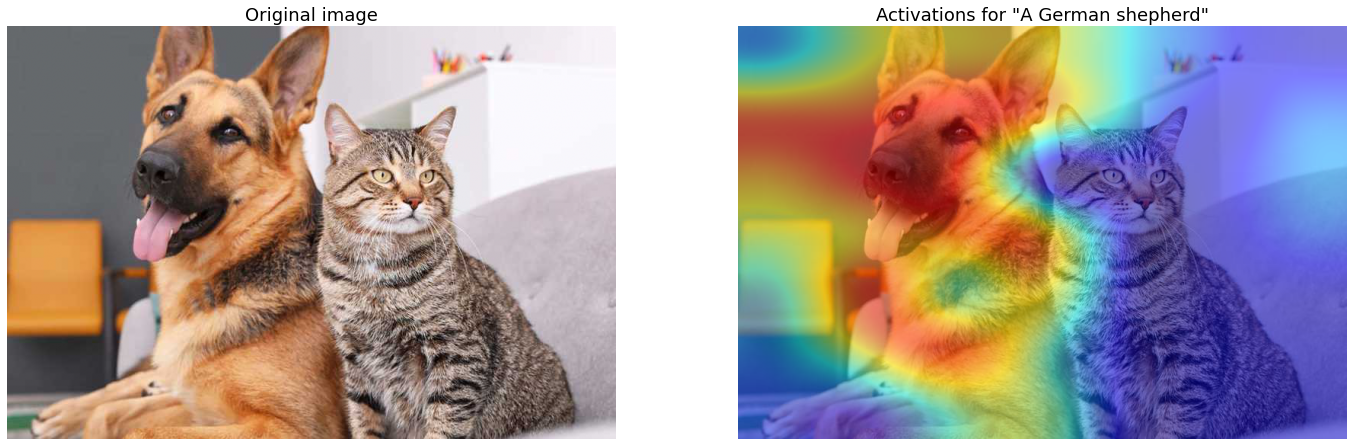

In [12]:
#@title #### Run on single image

image_url = 'https://images.ctfassets.net/82d3r48zq721/45liwTLsDMSJt4N22RqrHX/cd992f88ca8737f95b085212906d6d86/Can-cats-and-dogs-get-coronavirus_resized.jpg?w=800&q=50' #@param {type:"string"}
#@markdown or
image_path = '' #@param {type: "string"}
image_caption = 'A German shepherd' #@param {type:"string"}

assert(image_path != '' or image_url != '')

clip_image_path = 'image.png'
clip_image = None
if image_url != '':
  urllib.request.urlretrieve(image_url, clip_image_path)
elif image_path != '':
  clip_image_path = image_path
clip_image = Image.open(clip_image_path)

cam_logits = None

#Ease memory requirements on GPU
#Mostly useful for running batches/multiple images 
# with torch.no_grad():
#Process text and image inputs for obtaining embeddings 
text_input = processor([image_caption], 
          padding=True, return_tensors="pt").to(device)
text_img_input = processor([image_caption], images=clip_image, \
          padding=True, return_tensors='pt').to(device)

#Fetching components for GradCAM call, decomposed for readability
img_array = text_img_input['pixel_values']
text_embedding = model.get_text_features(**text_input).float()

"""Hugging Face CLIPModel and VisionTextDualEncoderModel instances
have slightly different layer-organization schemes. We will handle 
both in a simple try-except statement to fetch the desired layer
for GradCAM visualization."""
grad_layer = None
try:
  grad_layer = model.vision_model.vision_model.encoder.layers[int(attention_head)-1]
except:
  grad_layer = model.vision_model.encoder.layers[int(attention_head)-1]

#Generate attention map 
attn_map = gradCAM(
  model, 
  img_array,
  text_embedding,
  grad_layer
)

#Extract attn map
attn_map = attn_map.cpu().detach().numpy()[0,0]

#Process image and attention map for visualization
image_np = np.array(clip_image)/255
attn_map_resized = cv2.resize(attn_map, (clip_image.width, clip_image.height), interpolation = cv2.INTER_CUBIC )
attn_map_resized = np.repeat(attn_map_resized[:,:,np.newaxis], 3, axis=2)
attn_map_resized = normalize(attn_map_resized)

img_dim = None
if visualization_size == "small":
  img_dim = 6
elif visualization_size == "medium":
  img_dim = 9
else:
  img_dim = 12

fig, ax = plt.subplots(1, 2, figsize=(img_dim*2, img_dim))
ax[0].imshow(image_np)
ax[0].set_title("Original image", size=18)
if visualization_style == "heatmap":
  ax[1].imshow(show_cam_on_image(image_np, attn_map_resized, use_rgb=True))
else:
  ax[1].imshow(image_np * attn_map_resized)
ax[1].set_title(f'Activations for "{image_caption}"', size=18)
ax[0].axis('off');
ax[1].axis('off');

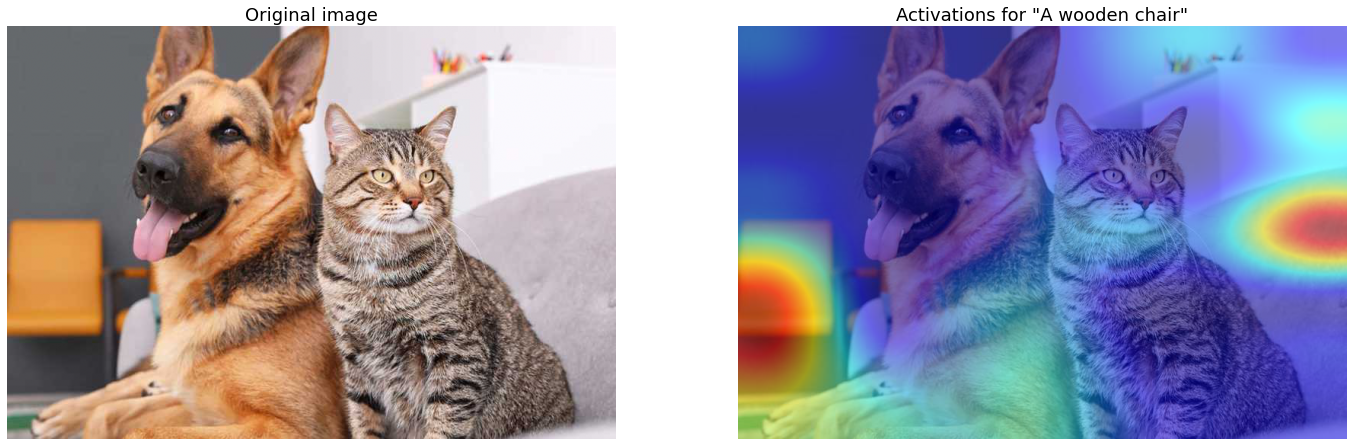

In [13]:
#@title #### Run on single image

image_url = 'https://images.ctfassets.net/82d3r48zq721/45liwTLsDMSJt4N22RqrHX/cd992f88ca8737f95b085212906d6d86/Can-cats-and-dogs-get-coronavirus_resized.jpg?w=800&q=50' #@param {type:"string"}
#@markdown or
image_path = '' #@param {type: "string"}
image_caption = 'A wooden chair' #@param {type:"string"}

assert(image_path != '' or image_url != '')

clip_image_path = 'image.png'
clip_image = None
if image_url != '':
  urllib.request.urlretrieve(image_url, clip_image_path)
elif image_path != '':
  clip_image_path = image_path
clip_image = Image.open(clip_image_path)

cam_logits = None

#Ease memory requirements on GPU
#Mostly useful for running batches/multiple images 
# with torch.no_grad():
#Process text and image inputs for obtaining embeddings 
text_input = processor([image_caption], 
          padding=True, return_tensors="pt").to(device)
text_img_input = processor([image_caption], images=clip_image, \
          padding=True, return_tensors='pt').to(device)

#Fetching components for GradCAM call, decomposed for readability
img_array = text_img_input['pixel_values']
text_embedding = model.get_text_features(**text_input).float()

"""Hugging Face CLIPModel and VisionTextDualEncoderModel instances
have slightly different layer-organization schemes. We will handle 
both in a simple try-except statement to fetch the desired layer
for GradCAM visualization."""
grad_layer = None
try:
  grad_layer = model.vision_model.vision_model.encoder.layers[int(attention_head)-1]
except:
  grad_layer = model.vision_model.encoder.layers[int(attention_head)-1]

#Generate attention map 
attn_map = gradCAM(
  model, 
  img_array,
  text_embedding,
  grad_layer
)

#Extract attn map
attn_map = attn_map.cpu().detach().numpy()[0,0]

#Process image and attention map for visualization
image_np = np.array(clip_image)/255
attn_map_resized = cv2.resize(attn_map, (clip_image.width, clip_image.height), interpolation = cv2.INTER_CUBIC )
attn_map_resized = np.repeat(attn_map_resized[:,:,np.newaxis], 3, axis=2)
attn_map_resized = normalize(attn_map_resized)

img_dim = None
if visualization_size == "small":
  img_dim = 6
elif visualization_size == "medium":
  img_dim = 9
else:
  img_dim = 12

fig, ax = plt.subplots(1, 2, figsize=(img_dim*2, img_dim))
ax[0].imshow(image_np)
ax[0].set_title("Original image", size=18)
if visualization_style == "heatmap":
  ax[1].imshow(show_cam_on_image(image_np, attn_map_resized, use_rgb=True))
else:
  ax[1].imshow(image_np * attn_map_resized)
ax[1].set_title(f'Activations for "{image_caption}"', size=18)
ax[0].axis('off');
ax[1].axis('off');